In [ ]:
import os
from datasets import load_dataset, Dataset
import datasets
import random
import numpy as np
from collections import Counter
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from sacremoses import MosesTokenizer

In [32]:
# Dirs
cwd= os.getcwd()
data_dir= os.path.join(cwd, "../data/")
artifacts_dir= os.path.join(cwd, "../artifacts/")
en_path= data_dir + 'UNPC.ar-en.en'
ar_path= data_dir + 'UNPC.ar-en.ar'
en_path= os.path.abspath(en_path)
ar_path= os.path.abspath(ar_path)

In [33]:
dataset= load_dataset('text', data_files= {'en': data_dir+'UNPC.ar-en.en',
                                           'ar': data_dir+'UNPC.ar-en.ar'})

In [34]:
for i in range(10):
    print(dataset['en'][i], dataset['ar'][i])

{'text': 'Distr.'} {'text': 'Distr.'}
{'text': 'GENERAL'} {'text': 'GENERAL'}
{'text': 'A/CN.4/452'} {'text': 'A/CN.4/452'}
{'text': '10 May 1993'} {'text': '10 May 1993'}
{'text': 'ORIGINAL: ENGLISH/SPANISH'} {'text': 'ORIGINAL: ENGLISH/SPANISH'}
{'text': 'INTERNATIONAL LAW COMMISSION'} {'text': 'لجنة القانون الدولي'}
{'text': 'Forty-fifth session'} {'text': 'الدورة الخامسة واﻷربعون'}
{'text': '3 May-23 July 1993'} {'text': '٣ أيار/ مايو - ٢٣ تموز/يوليه ١٩٩٣'}
{'text': 'COMMENTS OF GOVERNMENTS ON THE REPORT OF THE WORKING GROUP'} {'text': 'تعليقات الحكومات على تقرير الفريق العامل المعني'}
{'text': 'ON THE QUESTION OF AN INTERNATIONAL CRIMINAL JURISDICTION'} {'text': 'بمسألة إنشاء قضاء جنائي دولي'}


In [35]:
total_size= len(dataset['en']) # Total size for random sampling
subset_size= 1000000 # 1 Million sentence pair subset
# Random seed for reproducibility
random.seed(42)
indices= random.sample(range(total_size), subset_size)
# Sort indices for better memory access
indices.sort()

def pair_generator():
    for idx in indices:
        yield{
            'en': dataset['en'][idx]['text'], # Direct access without materializing full list
            'ar': dataset['ar'][idx]['text']
        }
# Build the dataset from generator
paired_ds= Dataset.from_generator(pair_generator)
# Checking size
print(f"Subset size: {len(paired_ds)}")


Generating train split: 0 examples [00:00, ? examples/s]

Subset size: 1000000


In [36]:
# Check a few samples to ensure alignment
for i in range(3):
    print(f"EN: {paired_ds[i]['en']}")
    print(f"AR: {paired_ds[i]['ar']}")
    print()

EN: &quot; 4. Takes note with appreciation of chapter II of the report of the International Law Commission, entitled &quot; Draft Code of Crimes against the Peace and Security of Mankind &quot; , which was devoted to the question of the possible establishment of an international criminal jurisdiction;
AR: &quot; ٤ - تحيط علما مع التقدير بالفصل الثاني من تقرير لجنة القانون الدولي، المعنون &quot; مشروع مدونة الجرائم المخلة بسلم اﻹنسانية وأمنها &quot; ، الذي كرس لمسألة إمكانية إنشاء قضاء جنائي دولي؛

EN: Structural and jurisdictional issues
AR: المسائل الهيكلية والمسائل المتعلقة بالوﻻية

EN: 6. Australia has already noted the importance of the Working Group &apos; s view expressed in paragraph 438 of the report that a court, at least in the first phase of its operations, should not be a full-time body but constituted on each occasion it was required to sit.
AR: ٦ - أشارت استراليا فعﻻ الى أهمية رأي الفريق العامل المعرب عنه في الفقرة ٤٣٨ مــن التقرير، ومؤداه أﻻ تكون للمحكمة، في مرحلة عملها 

EN words: avg=24.1, min=0, max=1191, std=20.0
AR words: avg=21.4, min=1, max=924, std=17.5
EN chars: avg=157.3, min=0, max=8135, std=132.5
AR chars: avg=132.4, min=1, max=6146, std=111.8


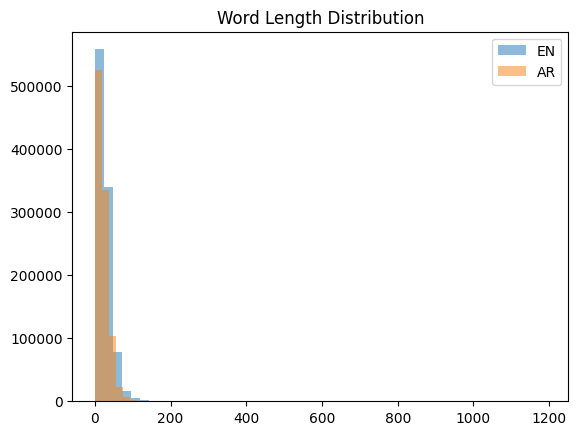

In [37]:
# Word-level lengths (using whitespace split as proxy)
en_word_lengths= [len(ex['en'].split()) for ex in paired_ds]
ar_word_lengths= [len(ex['ar'].split()) for ex in paired_ds]

# Char-level lengths (important for subword tokenization )
en_char_lengths= [len(ex['en']) for ex in paired_ds]
ar_char_lengths= [len(ex['ar']) for ex in paired_ds]

# Summarize
def print_stats(name, lengths):
    print(f"{name}: avg={np.mean(lengths):.1f}, min={np.min(lengths)}, max={np.max(lengths)}, std={np.std(lengths):.1f}")
    
print_stats("EN words", en_word_lengths)
print_stats("AR words", ar_word_lengths)
print_stats("EN chars", en_char_lengths)
print_stats("AR chars", ar_char_lengths)

# Plot histograms
import matplotlib.pyplot as plt
plt.hist(en_word_lengths, bins=50, alpha=0.5, label='EN')
plt.hist(ar_word_lengths, bins=50, alpha=0.5, label='AR')
plt.legend()
plt.title("Word Length Distribution")
plt.show()

In [38]:
# Flatten all words
en_words = [word for ex in paired_ds for word in ex['en'].lower().split()]
ar_words = [word for ex in paired_ds for word in ex['ar'].split()]  # Arabic split by space

# Compute word frequencies
en_word_freq = Counter(en_words)
ar_word_freq = Counter(ar_words)

# Top-k most common
print("Top 10 EN words:", en_word_freq.most_common(10))
print("Top 10 AR words:", ar_word_freq.most_common(10))

# Number of hapax legomena (words appearing only once)
en_hapax = sum(1 for count in en_word_freq.values() if count == 1)
ar_hapax = sum(1 for count in ar_word_freq.values() if count == 1)
print(f"EN unique words: {len(en_word_freq)}, of which {en_hapax} are hapax ({en_hapax/len(en_word_freq)*100:.1f}%)")
print(f"AR unique words: {len(ar_word_freq)}, of which {ar_hapax} are hapax ({ar_hapax/len(ar_word_freq)*100:.1f}%)")

Top 10 EN words: [('the', 2082540), ('of', 1253688), ('and', 917783), ('to', 727739), ('in', 582161), ('for', 292226), ('a', 280714), ('on', 264772), ('that', 225515), ('by', 166107)]
Top 10 AR words: [('في', 754286), ('من', 467485), ('على', 306179), ('إلى', 223562), ('أن', 207042), ('-', 185775), ('التي', 151852), ('عن', 125140), ('المتحدة', 101176), ('&quot;', 95929)]
EN unique words: 399601, of which 251326 are hapax (62.9%)
AR unique words: 711114, of which 418074 are hapax (58.8%)


In [39]:
import re

def normalize_numerals(text):
    """
    Convert Eastern Arabic numerals (٠-٩) to Western numerals (0-9)
    and standardize all number formatting
    """
    # Eastern to Western numeral mapping
    eastern_to_western = {
        '٠': '0', '١': '1', '٢': '2', '٣': '3', '٤': '4',
        '٥': '5', '٦': '6', '٧': '7', '٨': '8', '٩': '9'
    }
    
    # Convert Eastern Arabic numerals
    for eastern, western in eastern_to_western.items():
        text = text.replace(eastern, western)
    
    # Standardize number formatting (optional)
    text = re.sub(r'(\d)[\s,]*(\d)', r'\1\2', text)  # Remove spaces/commas within numbers
    
    return text

# Apply to both languages to ensure consistency
normalized_subset = paired_ds.map(lambda ex: {
    'en': normalize_numerals(ex['en']),
    'ar': normalize_numerals(ex['ar'])
})

Map:   0%|          | 0/1000000 [00:00<?, ? examples/s]

In [40]:
# Remove sentence pairs with number mismatch
def has_number_mismatch(example):
    en_has_numbers= bool(re.search(r'\d', example['en']))
    ar_has_numbers= bool(re.search(r'\d', example['ar']))
    return en_has_numbers != ar_has_numbers
# Filter out examples with number mismatches (numerals in one sentence but not in the other)
filtered_subset= normalized_subset.filter(
    lambda ex: not has_number_mismatch(ex)
)
print(f"Original size: {len(normalized_subset)}")
print(f"Filtered size: {len(filtered_subset)}")
print(f"Removed {len(normalized_subset) - len(filtered_subset)} mismatched pairs")

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Original size: 1000000
Filtered size: 954587
Removed 45413 mismatched pairs


In [ ]:
# Correlation between EN and AR word lengths
correlation = np.corrcoef(en_word_lengths, ar_word_lengths)[0,1]
print(f"Length correlation (EN vs AR words): {correlation:.3f}")

# Spot-check outliers: Pairs with large length ratios
ratios = [len(en.split()) / len(ar.split()) for en, ar in zip(filtered_subset['en'], filtered_subset['ar'])]
outlier_indices = np.where(np.array(ratios) > 2)[0]  # EN twice as long as AR
print(f"Found {len(outlier_indices)} potential misalignments (ratio > 2)")

In [66]:
if len(outlier_indices) > 0:
    print("Example outlier:", filtered_subset[int(outlier_indices[12])])

Example outlier: {'en': 'Peru 12 May 1978 10 August 1978 (2)', 'ar': '15 شباط/فبراير 1971)2('}


In [42]:
split_dataset= filtered_subset.train_test_split(test_size= 0.2, seed= 42)
train_ds= split_dataset['train']
val_ds= split_dataset['test']

# Verifying sizes
print(f"Train size: {len(train_ds)}")
print(f"Validation size: {len(val_ds)}")


Train size: 763669
Validation size: 190918


In [43]:
train_ds.save_to_disk(data_dir+"train_ds")
val_ds.save_to_disk(data_dir+"val_ds")

Saving the dataset (0/1 shards):   0%|          | 0/763669 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/190918 [00:00<?, ? examples/s]

In [44]:
# Create text file containing all training text for bpe tokenizer
with open(data_dir+'bpe_corpus_en.txt', 'w', encoding= 'utf-8') as f_en:
    with open(data_dir + 'bpe_corpus_ar.txt', 'w', encoding= 'utf-8') as f_ar:
        for example in train_ds:
            f_en.write(example['en'] + '\n')
            f_ar.write(example['ar'] + '\n')
    

In [45]:


# English tokenizer 
en_tokenizer = Tokenizer(BPE(unk_token="<UNK>"))
en_tokenizer.pre_tokenizer = Whitespace()
en_trainer = BpeTrainer(
    vocab_size=32000,
    special_tokens=["<UNK>", "<PAD>", "<SOS>", "<EOS>"],
    min_frequency=2
)

# Arabic tokenizer using built-in Moses pre-tokenizer
# Initialize Moses tokenizer for Arabic
mt = MosesTokenizer(lang='ar')

# Pre-tokenize the Arabic corpus
input_file = data_dir + 'bpe_corpus_ar.txt'
output_file = data_dir + 'bpe_corpus_ar_pre_tokenized.txt'

with open(input_file, 'r', encoding='utf-8') as f_in, open(output_file, 'w', encoding='utf-8') as f_out:
    for line in f_in:
        line = line.strip()
        if line:
            # Tokenize with Moses and join with spaces
            tokens = mt.tokenize(line, return_str=True)
            f_out.write(tokens + '\n')
        else:
            f_out.write('\n')

# Now train on the pre-tokenized corpus
ar_tokenizer = Tokenizer(BPE(unk_token="<UNK>"))
ar_tokenizer.pre_tokenizer = Whitespace()  # Simple whitespace

ar_trainer = BpeTrainer(
    vocab_size=45000,
    special_tokens=["<UNK>", "<PAD>", "<SOS>", "<EOS>"],
    min_frequency=2
)
# Training and saving
en_tokenizer.train(files=[data_dir+'bpe_corpus_en.txt'], trainer=en_trainer)
en_tokenizer.save(artifacts_dir + 'bpe_tokenizer_en.json')

ar_tokenizer.train(files=[data_dir+'bpe_corpus_ar.txt'], trainer=ar_trainer)
ar_tokenizer.save(artifacts_dir + 'bpe_tokenizer_ar.json')  # Save tokenizer

In [46]:
# Loading tokenizers
moses_pretokenizer= MosesTokenizer(lang='ar')
ar_tokenizer= Tokenizer.from_file(artifacts_dir+"bpe_tokenizer_ar.json")

en_tokenizer= Tokenizer.from_file(artifacts_dir+"bpe_tokenizer_en.json")

# Testing tokenizers
result = ar_tokenizer.encode("والكتابُ على الطاولةِ")
print(f"Arabic Tokenization: {result.tokens}")

result= en_tokenizer.encode("Metamorphosis of the worm")
print(f"English Tokenization: {result.tokens}")

Arabic Tokenization: ['وال', 'كتاب', 'ُ', 'على', 'الط', 'اولة', 'ِ']
English Tokenization: ['Met', 'am', 'orph', 'osis', 'of', 'the', 'wor', 'm']


In [48]:
# Test English tokenizer
en_sample = "The quick brown fox jumps over 123 lazy dogs"
en_encoded = en_tokenizer.encode(en_sample)
print("English tokens:", en_encoded.tokens)
print("English IDs:", en_encoded.ids)

# Test Arabic tokenizer with complex example
ar_sample = "والكتابُ الجديد على الطاولةِ يحتوي على 123 صفحة"
ar_encoded = ar_tokenizer.encode(ar_sample)
print("Arabic tokens:", ar_encoded.tokens)
print("Arabic IDs:", ar_encoded.ids)

English tokens: ['The', 'quick', 'brow', 'n', 'fo', 'x', 'jum', 'ps', 'over', '123', 'la', 'zy', 'dogs']
English IDs: [828, 6469, 29820, 77, 3641, 87, 29261, 3779, 890, 7762, 1000, 19627, 25515]
Arabic tokens: ['وال', 'كتاب', 'ُ', 'الجديد', 'على', 'الط', 'اولة', 'ِ', 'يحتوي', 'على', '123', 'صفحة']
Arabic IDs: [1158, 12839, 343, 3652, 1156, 1323, 26373, 344, 17158, 1156, 9712, 8985]
